In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import keras
from keras import Sequential, utils
from keras.layers import Flatten, Dense

In [3]:
global trainData, testData, genderSubmissionData
trainDataDirectory = "/titanic/train.csv"
testDataDirectory = "/titanic/test.csv"
genderSubmissionDirectory = "/titanic/gender_submission.csv"

In [4]:
for dirname, _, filenames in os.walk("titanic/"):
  for filename in filenames:
      csv = os.path.join(dirname, filename)
      if filename in trainDataDirectory:
          trainData = pd.read_csv(csv)
      elif filename in testDataDirectory:
          testData = pd.read_csv(csv)
      elif filename in genderSubmissionDirectory:
          genderSubmissionData = pd.read_csv(csv)
      else:
              pass

In [5]:
trainData

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [ ]:
ss = trainData[["Sex", "Survived"]].groupby(["Sex"], as_index=False).mean()
ss

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [ ]:
ps = trainData[["Pclass", "Survived"]].groupby(["Pclass"], as_index=False).mean()
ps

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [ ]:
ageS = trainData[["Age", "Survived"]].dropna()
ageS

,Age,Survived
0,22.0,0
1,38.0,1
2,26.0,1
3,35.0,1
4,35.0,0
...,...,...
885,39.0,0
886,27.0,0
887,19.0,1
889,26.0,1


In [ ]:
testData[["Title", "Pclass"]].groupby(["Title"], as_index=False).mean()

,Title,Pclass
0,Col,1.000000
1,Dona,1.000000
2,Dr,1.000000
3,Master,2.714286
4,Miss,2.435897
5,Mr,2.320833
6,Mrs,1.833333
7,Ms,3.000000
8,Rev,2.000000


In [ ]:
ts = trainData[["Title", "Survived"]].groupby(["Title"], as_index=False).mean()
ts

,Title,Survived
0,Capt,0.000000
1,Col,0.500000
2,Countess,1.000000
3,Don,0.000000
4,Dr,0.428571
5,Jonkheer,0.000000
6,Lady,1.000000
7,Major,0.500000
8,Master,0.575000
9,Miss,0.697802


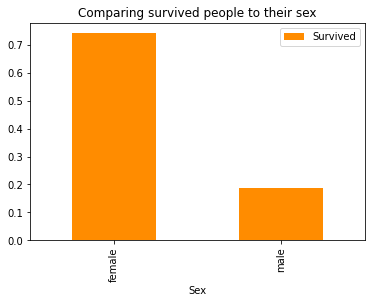

In [ ]:
ss.plot(x="Sex", y="Survived", kind="bar", title="Comparing survived people to their sex", color="DarkOrange")

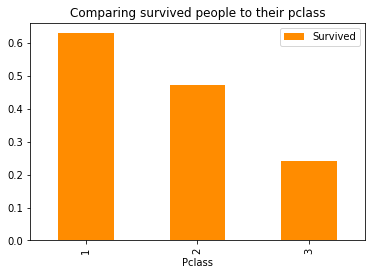

In [ ]:
ps.plot(x ="Pclass", y="Survived", kind="bar", title="Comparing survived people to their pclass", color="DarkOrange")

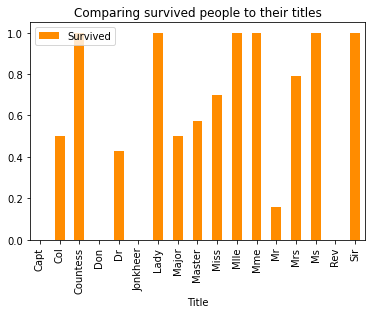

In [ ]:
ts.plot(x="Title", y="Survived", kind="bar", title="Comparing survived people to their titles", color="DarkOrange")

Preparation of dataset

In [7]:
trainData["Title"] = trainData.Name.str.extract("([A-Za-z]+)\.", expand=False)
testData["Title"] = testData.Name.str.extract("([A-Za-z]+)\.", expand=False)

In [8]:
titles = {"Capt" : 1, "Col" : 2, "Countess" : 3, "Don" : 4, "Dr" : 5, "Jonkheer" : 6, "Lady" : 7, "Major" : 8, "Master" : 9, "Miss" : 10, "Mlle" : 11, "Mme" : 12, "Mr" : 13, "Mrs" : 14, "Ms" : 15, "Rev" : 16, "Sir" : 17, "Dona" : 18}
trainData["Title"] = trainData["Title"].map(titles).astype(int)
testData["Title"] = testData["Title"].map(titles).astype(int)

In [9]:
sex = {"male" : 1, "female" : 2}
trainData["Sex"] = trainData["Sex"].map(sex).astype(int)
testData["Sex"] = testData["Sex"].map(sex).astype(int)

In [10]:
embarked = {"S" : 1, "C" : 2, "Q" : 3}
trainData["Embarked"] = trainData["Embarked"].dropna().map(embarked).astype(int)
testData["Embarked"] = testData["Embarked"].dropna().map(embarked).astype(int)

In [11]:
trainData["Fare"].fillna(trainData["Fare"].dropna().median(), inplace=True)
testData["Fare"].fillna(testData["Fare"].dropna().median(), inplace=True)
trainData

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,1.0,13
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",2,38.0,1,0,PC 17599,71.2833,C85,2.0,14
2,3,1,3,"Heikkinen, Miss. Laina",2,26.0,0,0,STON/O2. 3101282,7.9250,NaN,1.0,10
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",2,35.0,1,0,113803,53.1000,C123,1.0,14
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,1.0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",1,27.0,0,0,211536,13.0000,NaN,1.0,16
887,888,1,1,"Graham, Miss. Margaret Edith",2,19.0,0,0,112053,30.0000,B42,1.0,10
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",2,NaN,1,2,W./C. 6607,23.4500,NaN,1.0,10
889,890,1,1,"Behr, Mr. Karl Howell",1,26.0,0,0,111369,30.0000,C148,2.0,13


In [12]:
trainData["FareGrouped"] = pd.qcut(trainData["Fare"], 4)
trainData[["FareGrouped", "Survived"]].groupby(["FareGrouped"], as_index=False).mean().sort_values(by="FareGrouped", ascending=True)
trainData

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FareGrouped
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,1.0,13,"(-0.001, 7.91]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",2,38.0,1,0,PC 17599,71.2833,C85,2.0,14,"(31.0, 512.329]"
2,3,1,3,"Heikkinen, Miss. Laina",2,26.0,0,0,STON/O2. 3101282,7.9250,NaN,1.0,10,"(7.91, 14.454]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",2,35.0,1,0,113803,53.1000,C123,1.0,14,"(31.0, 512.329]"
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,1.0,13,"(7.91, 14.454]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",1,27.0,0,0,211536,13.0000,NaN,1.0,16,"(7.91, 14.454]"
887,888,1,1,"Graham, Miss. Margaret Edith",2,19.0,0,0,112053,30.0000,B42,1.0,10,"(14.454, 31.0]"
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",2,NaN,1,2,W./C. 6607,23.4500,NaN,1.0,10,"(14.454, 31.0]"
889,890,1,1,"Behr, Mr. Karl Howell",1,26.0,0,0,111369,30.0000,C148,2.0,13,"(14.454, 31.0]"


In [13]:
trainData.loc[ trainData["Fare"] <= 7.91, "Fare"] = 0
trainData.loc[(trainData["Fare"] > 7.91) & (trainData["Fare"] <= 14.454), "Fare"] = 1
trainData.loc[(trainData["Fare"] > 14.454) & (trainData["Fare"] <= 31), "Fare"]   = 2
trainData.loc[ trainData["Fare"] > 31, "Fare"] = 3
trainData["Fare"] = trainData["Fare"].astype(int)

testData.loc[ testData["Fare"] <= 7.91, "Fare"] = 0
testData.loc[(testData["Fare"] > 7.91) & (testData["Fare"] <= 14.454), "Fare"] = 1
testData.loc[(testData["Fare"] > 14.454) & (testData["Fare"] <= 31), "Fare"]   = 2
testData.loc[ testData["Fare"] > 31, "Fare"] = 3
testData["Fare"] = testData["Fare"].astype(int)

In [14]:
trainData["AgeGrouped"] = pd.cut(trainData["Age"], 5)
trainData

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FareGrouped,AgeGrouped
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,0,NaN,1.0,13,"(-0.001, 7.91]","(16.336, 32.252]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",2,38.0,1,0,PC 17599,3,C85,2.0,14,"(31.0, 512.329]","(32.252, 48.168]"
2,3,1,3,"Heikkinen, Miss. Laina",2,26.0,0,0,STON/O2. 3101282,1,NaN,1.0,10,"(7.91, 14.454]","(16.336, 32.252]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",2,35.0,1,0,113803,3,C123,1.0,14,"(31.0, 512.329]","(32.252, 48.168]"
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,1,NaN,1.0,13,"(7.91, 14.454]","(32.252, 48.168]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",1,27.0,0,0,211536,1,NaN,1.0,16,"(7.91, 14.454]","(16.336, 32.252]"
887,888,1,1,"Graham, Miss. Margaret Edith",2,19.0,0,0,112053,2,B42,1.0,10,"(14.454, 31.0]","(16.336, 32.252]"
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",2,NaN,1,2,W./C. 6607,2,NaN,1.0,10,"(14.454, 31.0]",NaN
889,890,1,1,"Behr, Mr. Karl Howell",1,26.0,0,0,111369,2,C148,2.0,13,"(14.454, 31.0]","(16.336, 32.252]"


In [17]:
at = trainData[["Age", "Title"]].groupby(["Title"], as_index=False).mean()
at = at.set_index(["Title"])
at

,Age
Title,
1,70.000000
2,58.000000
3,33.000000
4,40.000000
5,42.000000
6,38.000000
7,48.000000
8,48.500000
9,4.574167


In [15]:
ageTable = trainData[trainData["Age"].isnull()]
ageTable

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FareGrouped,AgeGrouped
5,6,0,3,"Moran, Mr. James",1,NaN,0,0,330877,1,NaN,3.0,13,"(7.91, 14.454]",NaN
17,18,1,2,"Williams, Mr. Charles Eugene",1,NaN,0,0,244373,1,NaN,1.0,13,"(7.91, 14.454]",NaN
19,20,1,3,"Masselmani, Mrs. Fatima",2,NaN,0,0,2649,0,NaN,2.0,14,"(-0.001, 7.91]",NaN
26,27,0,3,"Emir, Mr. Farred Chehab",1,NaN,0,0,2631,0,NaN,2.0,13,"(-0.001, 7.91]",NaN
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",2,NaN,0,0,330959,0,NaN,3.0,10,"(-0.001, 7.91]",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",1,NaN,0,0,2629,0,NaN,2.0,13,"(-0.001, 7.91]",NaN
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",2,NaN,8,2,CA. 2343,3,NaN,1.0,10,"(31.0, 512.329]",NaN
868,869,0,3,"van Melkebeke, Mr. Philemon",1,NaN,0,0,345777,1,NaN,1.0,13,"(7.91, 14.454]",NaN
878,879,0,3,"Laleff, Mr. Kristo",1,NaN,0,0,349217,0,NaN,1.0,13,"(-0.001, 7.91]",NaN


In [18]:
for i in ageTable.index.tolist():
  trainData.at[i, "Age"] = at.loc[ageTable.at[i, "Title"]]
trainData

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FareGrouped,AgeGrouped
0,1,0,3,"Braund, Mr. Owen Harris",1,22.000000,1,0,A/5 21171,0,NaN,1.0,13,"(-0.001, 7.91]","(16.336, 32.252]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",2,38.000000,1,0,PC 17599,3,C85,2.0,14,"(31.0, 512.329]","(32.252, 48.168]"
2,3,1,3,"Heikkinen, Miss. Laina",2,26.000000,0,0,STON/O2. 3101282,1,NaN,1.0,10,"(7.91, 14.454]","(16.336, 32.252]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",2,35.000000,1,0,113803,3,C123,1.0,14,"(31.0, 512.329]","(32.252, 48.168]"
4,5,0,3,"Allen, Mr. William Henry",1,35.000000,0,0,373450,1,NaN,1.0,13,"(7.91, 14.454]","(32.252, 48.168]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",1,27.000000,0,0,211536,1,NaN,1.0,16,"(7.91, 14.454]","(16.336, 32.252]"
887,888,1,1,"Graham, Miss. Margaret Edith",2,19.000000,0,0,112053,2,B42,1.0,10,"(14.454, 31.0]","(16.336, 32.252]"
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",2,21.773973,1,2,W./C. 6607,2,NaN,1.0,10,"(14.454, 31.0]",NaN
889,890,1,1,"Behr, Mr. Karl Howell",1,26.000000,0,0,111369,2,C148,2.0,13,"(14.454, 31.0]","(16.336, 32.252]"


In [19]:
ageTableTest = testData[testData["Age"].isnull()]
ageTableTest

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
10,902,3,"Ilieff, Mr. Ylio",1,NaN,0,0,349220,0,NaN,1,13
22,914,1,"Flegenheim, Mrs. Alfred (Antoinette)",2,NaN,0,0,PC 17598,3,NaN,1,14
29,921,3,"Samaan, Mr. Elias",1,NaN,2,0,2662,2,NaN,2,13
33,925,3,"Johnston, Mrs. Andrew G (Elizabeth Lily"" Watson)""",2,NaN,1,2,W./C. 6607,2,NaN,1,14
36,928,3,"Roth, Miss. Sarah A",2,NaN,0,0,342712,1,NaN,1,10
...,...,...,...,...,...,...,...,...,...,...,...,...
408,1300,3,"Riordan, Miss. Johanna Hannah""""",2,NaN,0,0,334915,0,NaN,3,10
410,1302,3,"Naughton, Miss. Hannah",2,NaN,0,0,365237,0,NaN,3,10
413,1305,3,"Spector, Mr. Woolf",1,NaN,0,0,A.5. 3236,1,NaN,1,13
416,1308,3,"Ware, Mr. Frederick",1,NaN,0,0,359309,1,NaN,1,13


In [20]:
for i in ageTableTest.index.tolist():
  testData.at[i, "Age"] = at.loc[ageTableTest.at[i, "Title"]]
testData

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,"Kelly, Mr. James",1,34.500000,0,0,330911,0,NaN,3,13
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",2,47.000000,1,0,363272,0,NaN,1,14
2,894,2,"Myles, Mr. Thomas Francis",1,62.000000,0,0,240276,1,NaN,3,13
3,895,3,"Wirz, Mr. Albert",1,27.000000,0,0,315154,1,NaN,1,13
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",2,22.000000,1,1,3101298,1,NaN,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",1,32.368090,0,0,A.5. 3236,1,NaN,1,13
414,1306,1,"Oliva y Ocana, Dona. Fermina",2,39.000000,0,0,PC 17758,3,C105,2,18
415,1307,3,"Saether, Mr. Simon Sivertsen",1,38.500000,0,0,SOTON/O.Q. 3101262,0,NaN,1,13
416,1308,3,"Ware, Mr. Frederick",1,32.368090,0,0,359309,1,NaN,1,13


In [21]:
trainData.loc[trainData["Age"] <= 16, "Age"] = 0
trainData.loc[(trainData["Age"] > 16) & (trainData["Age"] <= 32), "Age"] = 1
trainData.loc[(trainData["Age"] > 32) & (trainData["Age"] <= 48), "Age"] = 2
trainData.loc[(trainData["Age"] > 48) & (trainData["Age"] <= 64), "Age"] = 3
trainData.loc[trainData["Age"] > 64, "Age"] = 4
trainData

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FareGrouped,AgeGrouped
0,1,0,3,"Braund, Mr. Owen Harris",1,1.0,1,0,A/5 21171,0,NaN,1.0,13,"(-0.001, 7.91]","(16.336, 32.252]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",2,2.0,1,0,PC 17599,3,C85,2.0,14,"(31.0, 512.329]","(32.252, 48.168]"
2,3,1,3,"Heikkinen, Miss. Laina",2,1.0,0,0,STON/O2. 3101282,1,NaN,1.0,10,"(7.91, 14.454]","(16.336, 32.252]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",2,2.0,1,0,113803,3,C123,1.0,14,"(31.0, 512.329]","(32.252, 48.168]"
4,5,0,3,"Allen, Mr. William Henry",1,2.0,0,0,373450,1,NaN,1.0,13,"(7.91, 14.454]","(32.252, 48.168]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",1,1.0,0,0,211536,1,NaN,1.0,16,"(7.91, 14.454]","(16.336, 32.252]"
887,888,1,1,"Graham, Miss. Margaret Edith",2,1.0,0,0,112053,2,B42,1.0,10,"(14.454, 31.0]","(16.336, 32.252]"
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",2,1.0,1,2,W./C. 6607,2,NaN,1.0,10,"(14.454, 31.0]",NaN
889,890,1,1,"Behr, Mr. Karl Howell",1,1.0,0,0,111369,2,C148,2.0,13,"(14.454, 31.0]","(16.336, 32.252]"


In [22]:
testData.loc[testData["Age"] <= 16, "Age"] = 0
testData.loc[(testData["Age"] > 16) & (testData["Age"] <= 32), "Age"] = 1
testData.loc[(testData["Age"] > 32) & (testData["Age"] <= 48), "Age"] = 2
testData.loc[(testData["Age"] > 48) & (testData["Age"] <= 64), "Age"] = 3
testData.loc[testData["Age"] > 64, "Age"] = 4
testData

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,"Kelly, Mr. James",1,2.0,0,0,330911,0,NaN,3,13
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",2,2.0,1,0,363272,0,NaN,1,14
2,894,2,"Myles, Mr. Thomas Francis",1,3.0,0,0,240276,1,NaN,3,13
3,895,3,"Wirz, Mr. Albert",1,1.0,0,0,315154,1,NaN,1,13
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",2,1.0,1,1,3101298,1,NaN,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",1,2.0,0,0,A.5. 3236,1,NaN,1,13
414,1306,1,"Oliva y Ocana, Dona. Fermina",2,2.0,0,0,PC 17758,3,C105,2,18
415,1307,3,"Saether, Mr. Simon Sivertsen",1,2.0,0,0,SOTON/O.Q. 3101262,0,NaN,1,13
416,1308,3,"Ware, Mr. Frederick",1,2.0,0,0,359309,1,NaN,1,13


In [34]:
trainData = trainData.drop(["PassengerId", "Name", "Cabin", "Ticket", "FareGrouped", "AgeGrouped"], axis=1)
testData = testData.drop(["PassengerId", "Name", "Cabin", "Ticket", "FareGrouped", "AgeGrouped"], axis=1)

In [37]:
trainData["Embarked"] = trainData["Embarked"].fillna(0)
testData["Embarked"] = testData["Embarked"].fillna(0)

In [38]:
trainData["Title"] = trainData["Title"].fillna(0)
testData["Title"] = testData["Title"].fillna(0)

In [39]:
msk = np.random.rand(len(trainData)) < 0.8
train = trainData[msk]
validate = trainData[~msk]

In [40]:
x_train = train[train.columns[~train.columns.isin(["Survived"])]]
y_train = train["Survived"]
x_test = validate[train.columns[~train.columns.isin(["Survived"])]]
y_test = validate["Survived"]

In [41]:
y_train = utils.to_categorical(y_train, num_classes=2)
y_test = utils.to_categorical(y_test, num_classes=2)

In [42]:
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

In [43]:
x_train

array([[ 1.,  2.,  2., ...,  3.,  2., 14.],
       [ 1.,  2.,  2., ...,  3.,  1., 14.],
       [ 3.,  1.,  2., ...,  1.,  1., 13.],
       ...,
       [ 3.,  2.,  1., ...,  2.,  1., 10.],
       [ 1.,  1.,  1., ...,  2.,  2., 13.],
       [ 3.,  1.,  1., ...,  0.,  3., 13.]])

In [44]:
x_train_norm = (x_train - x_train.mean()) / x_train.std()
x_test_norm = (x_test - x_test.mean()) / x_test.std()

In [45]:
x_train_norm.shape

(706, 8)

In [46]:
x_test_norm.shape

(185, 8)

In [53]:
def createModel():

  addModel = Sequential()

  addModel.add(Dense(256, activation="relu", input_shape=(x_train_norm.shape[1],)))
  addModel.add(Dense(128, activation="relu"))
  addModel.add(Dense(2, activation="softmax"))

  addModel.compile(loss="binary_crossentropy", 
                  optimizer="adam", 
                  metrics=["accuracy"])
  return addModel

In [55]:
model = createModel()
model.fit(x_train_norm, y_train, validation_data=(x_test_norm, y_test), validation_split=0.3, epochs=1000, verbose=2)

Train on 706 samples, validate on 185 samples
Epoch 1/1000
 - 0s - loss: 0.6295 - accuracy: 0.6388 - val_loss: 0.5697 - val_accuracy: 0.7459
Epoch 2/1000
 - 0s - loss: 0.5696 - accuracy: 0.6969 - val_loss: 0.5170 - val_accuracy: 0.7622
Epoch 3/1000
 - 0s - loss: 0.5330 - accuracy: 0.7436 - val_loss: 0.4995 - val_accuracy: 0.7351
Epoch 4/1000
 - 0s - loss: 0.5307 - accuracy: 0.7351 - val_loss: 0.4449 - val_accuracy: 0.7676
Epoch 5/1000
 - 0s - loss: 0.4923 - accuracy: 0.7720 - val_loss: 0.4285 - val_accuracy: 0.8054
Epoch 6/1000
 - 0s - loss: 0.4744 - accuracy: 0.7833 - val_loss: 0.4155 - val_accuracy: 0.7946
Epoch 7/1000
 - 0s - loss: 0.4662 - accuracy: 0.7918 - val_loss: 0.4129 - val_accuracy: 0.8270
Epoch 8/1000
 - 0s - loss: 0.4544 - accuracy: 0.8102 - val_loss: 0.3911 - val_accuracy: 0.8270
Epoch 9/1000
 - 0s - loss: 0.4598 - accuracy: 0.7932 - val_loss: 0.3967 - val_accuracy: 0.8324
Epoch 10/1000
 - 0s - loss: 0.4670 - accuracy: 0.7833 - val_loss: 0.3878 - val_accuracy: 0.8541
Epo

In [56]:
prediction = model.predict(x_test_norm)

In [77]:
accuracy = 0
for i in range(len(prediction)):
  if y_test[i][0] - prediction[i][0] < 0.3:
    accuracy += 1
    # print(format(prediction[i][0], ".2f"), y_test[i][0])
print("Accuracy of predictions is: ", str(accuracy/len(prediction)*100) + "%")

Accuracy of predictions is:  90.27027027027027%
